In [2]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-11-29 06:48:39--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   142MB/s    in 0.6s    

2021-11-29 06:48:39 (142 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

In [3]:
import pandas as pd
import numpy as np
from rdkit import Chem
from tqdm import tqdm
from rdkit.Chem import Descriptors, Lipinski

In [4]:
path = '/content/drive/MyDrive/current_work/ML-Serotonin-Mol-Activity/serotonin_5_ht_2a_receptor_bioactivity_comp.csv'

data = pd.read_csv(path)

In [5]:
data

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL128,CNS(=O)(=O)Cc1ccc2[nH]cc(CCN(C)C)c2c1,7943.28,intermediate
1,CHEMBL905,CN(C)CCc1c[nH]c2ccc(Cn3cncn3)cc12,7943.28,intermediate
2,CHEMBL128,CNS(=O)(=O)Cc1ccc2[nH]cc(CCN(C)C)c2c1,10000.00,inactive
3,CHEMBL292779,Fc1cccc(CCN2CCN(CCCc3c[nH]c4ccc(-n5cnnc5)cc34)...,370.00,active
4,CHEMBL83220,CN(CC1CC2c3ccccc3Cc3ccccc3N2O1)C(=O)C(F)(F)F,1000.00,active
...,...,...,...,...
1698,CHEMBL4635373,COc1c(OCCOCCOCCOCCOCCOc2ccc(C3CCN(c4ccn5c(CC6C...,446.68,NaN
1699,CHEMBL4638687,COc1c(OCCOCCOCCOCCOCCOCCOc2ccc(C3CCN(c4ccn5c(C...,275.42,NaN
1700,CHEMBL4645193,COc1c(OCCOCCOCCOCCOCCOCCOCCOCCOc2ccc(C3CCN(c4c...,407.38,NaN
1701,CHEMBL4641860,COc1c(OCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOc2ccc(C3C...,302.00,NaN


In [6]:
data.dropna(inplace=True)

In [7]:
temp = list()

for idx, smile in tqdm(enumerate(data.canonical_smiles)):

  mol = Chem.MolFromSmiles(smile) 

  mol_wgt = Descriptors.MolWt(mol)
  logp = Descriptors.MolLogP(mol)
  h_donor = Lipinski.NumHDonors(mol)
  h_acc = Lipinski.NumHAcceptors(mol)

  temp.append(list((mol_wgt, logp, h_donor, h_acc)))

651it [00:00, 1366.55it/s]


In [8]:
lipinski_df = pd.DataFrame(np.array(temp), columns=['MolW', 'LogP', 'HDonor', 'HAcceptor'])

In [9]:
data_1 = pd.concat([data,lipinski_df], axis=1, join="inner")

In [10]:
data_1

,molecule_chembl_id,canonical_smiles,standard_value,class,MolW,LogP,HDonor,HAcceptor
0,CHEMBL128,CNS(=O)(=O)Cc1ccc2[nH]cc(CCN(C)C)c2c1,7943.28,intermediate,295.408,1.32120,2.0,3.0
1,CHEMBL905,CN(C)CCc1c[nH]c2ccc(Cn3cncn3)cc12,7943.28,intermediate,269.352,1.91180,1.0,4.0
2,CHEMBL128,CNS(=O)(=O)Cc1ccc2[nH]cc(CCN(C)C)c2c1,10000.00,inactive,295.408,1.32120,2.0,3.0
3,CHEMBL292779,Fc1cccc(CCN2CCN(CCCc3c[nH]c4ccc(-n5cnnc5)cc34)...,370.00,active,432.547,3.68060,1.0,5.0
4,CHEMBL83220,CN(CC1CC2c3ccccc3Cc3ccccc3N2O1)C(=O)C(F)(F)F,1000.00,active,376.378,3.86310,0.0,3.0
...,...,...,...,...,...,...,...,...
574,CHEMBL3216499,Cc1nc(C(=O)NCCCN2CCN(c3cccc(Cl)c3Cl)CC2)c(C)n1...,30.00,active,703.197,7.50044,1.0,5.0
575,CHEMBL3215849,CCCc1nc(C(=O)NCCCN2CCN(c3cccc(Cl)c3Cl)CC2)cn1-...,70.90,active,717.224,7.83610,1.0,5.0
589,CHEMBL221753,CC(C)(C)CC(C)(C)c1ccc(OCCOCC[N+](C)(C)Cc2ccccc...,129.00,active,469.669,7.21760,0.0,3.0
605,CHEMBL49,O=C1CC2(CCCC2)CC(=O)N1CCCCN1CCN(c2ncccn2)CC1,2286.00,intermediate,274.795,3.81860,0.0,2.0


In [11]:
data_1.standard_value.describe()

count       579.000000
mean       1451.260487
std        9297.453101
min           0.251200
25%          26.850000
50%         107.000000
75%         620.000000
max      213796.210000
Name: standard_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feaa46314d0>]],
      dtype=object)

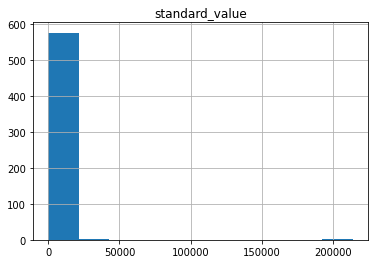

In [12]:
data_1.hist(column='standard_value')

In [13]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

def pIC50(input):
    pIC50 = []

    for i in input['standard_value']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value', 1)
        
    return x

In [14]:
data_1_final = pIC50(data_1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea9ee8af10>]],
      dtype=object)

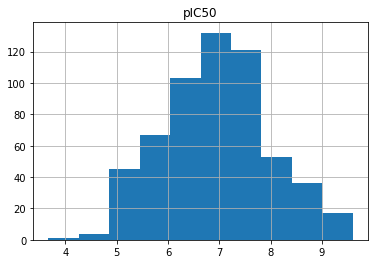

In [15]:
data_1_final.hist(column='pIC50')

In [16]:
data_1_final.head()

,molecule_chembl_id,canonical_smiles,class,MolW,LogP,HDonor,HAcceptor,pIC50
0,CHEMBL128,CNS(=O)(=O)Cc1ccc2[nH]cc(CCN(C)C)c2c1,intermediate,295.408,1.3212,2.0,3.0,5.100000
1,CHEMBL905,CN(C)CCc1c[nH]c2ccc(Cn3cncn3)cc12,intermediate,269.352,1.9118,1.0,4.0,5.100000
2,CHEMBL128,CNS(=O)(=O)Cc1ccc2[nH]cc(CCN(C)C)c2c1,inactive,295.408,1.3212,2.0,3.0,5.000000
3,CHEMBL292779,Fc1cccc(CCN2CCN(CCCc3c[nH]c4ccc(-n5cnnc5)cc34)...,active,432.547,3.6806,1.0,5.0,6.431798
4,CHEMBL83220,CN(CC1CC2c3ccccc3Cc3ccccc3N2O1)C(=O)C(F)(F)F,active,376.378,3.8631,0.0,3.0,6.000000


In [18]:
data_1_final['class'].value_counts()

active          495
intermediate     52
inactive         32
Name: class, dtype: int64

In [19]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

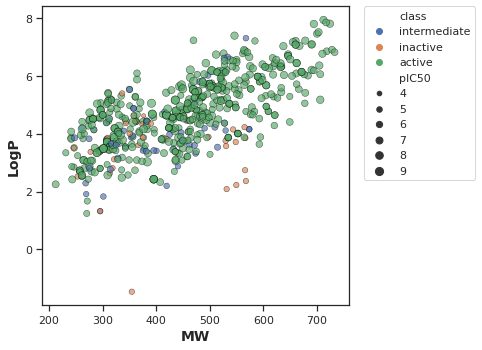

In [20]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MolW', y='LogP', data=data_1_final, hue='class', size='pIC50', edgecolor='black', alpha=0.65)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

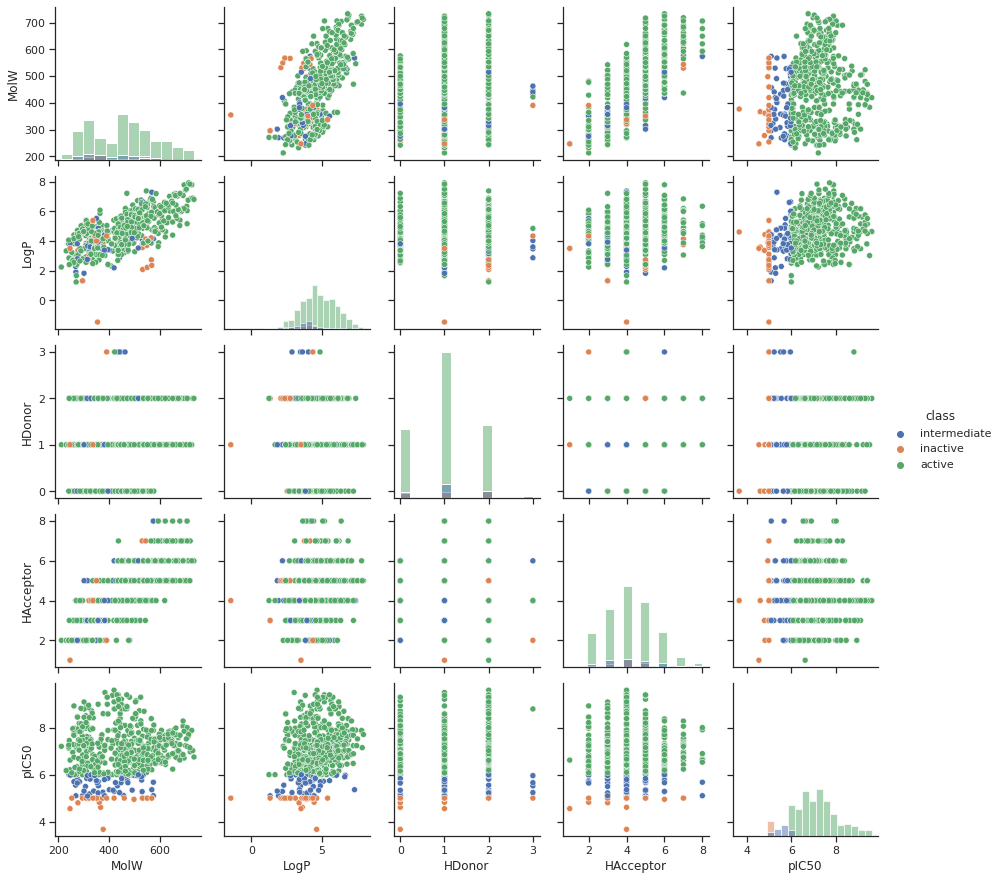

In [24]:
g = sns.PairGrid(data_1_final, hue="class")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()